In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from fastai.tabular.core import add_datepart
from pandas import DataFrame, concat
from sklearn.metrics import mean_absolute_error

In [ ]:
# Скачивание данныъх
data = pd.read_csv("https://raw.githubusercontent.com/dmitry-chvdr/aqi_prediction/Checkpoint4/ts_air_quality_index_2013_2020.csv")

# Добавим данные привязку к дню года
add_datepart(data, 'Date', drop=False)
for character in ["Is_month_end", "Is_month_start", "Is_quarter_end", "Is_quarter_start", "Is_year_end", "Is_year_start"]:
  data[f'{character}'] = data[f'{character}'].map({True:1,False:0})

# Разбиваем на трейн тест
x_train = data.iloc[:-80]
x_test = data.iloc[-80:]

y_train = data['aqi'].iloc[:-80]
y_test = data['aqi'].iloc[-80:]

df = data[["CO_index", "PM10_index", "PM2.5_index", "SO2_index", "O3_index", "NO2_index"]]

In [ ]:
# Преобразуем исходнные данные для построения модели на всех "подиндексах" качества воздуха.
data1 = x_train[["CO_index", "PM10_index", "PM2.5_index", "SO2_index",
                 "O3_index", "NO2_index", "Day", "Dayofweek",
                 "Dayofyear", "Is_month_end", "Is_month_start",
                 "Is_quarter_end", "Is_quarter_start", "Is_year_end",
                 "Is_year_start"]]
data2 = x_test[["CO_index", "PM10_index", "PM2.5_index", "SO2_index",
                "O3_index", "NO2_index", "Day", "Dayofweek", "Dayofyear",
                "Is_month_end", "Is_month_start", "Is_quarter_end",
                "Is_quarter_start", "Is_year_end", "Is_year_start"]]

# Формируем тренировочный и тестовый датасеты
df_xtrain = data1[["CO_index", "PM10_index", "PM2.5_index",
                   "SO2_index", "O3_index", "NO2_index", "Day",
                   "Dayofweek", "Dayofyear", "Is_month_end", "Is_month_start",
                   "Is_quarter_end", "Is_quarter_start", "Is_year_end", "Is_year_start"]]
df_xtest = data2[["CO_index", "PM10_index", "PM2.5_index", "SO2_index",
                  "O3_index", "NO2_index", "Day", "Dayofweek", "Dayofyear",
                  "Is_month_end", "Is_month_start", "Is_quarter_end",
                  "Is_quarter_start", "Is_year_end", "Is_year_start"]]

# Cформируем датасеты для построения временного окна
dfxtrain = DataFrame()
dfxtest = DataFrame()

# Выполняет построение временного окна путем сдвига исходного датасета
# Train
for day in df_xtrain:
    dfxtrain[f'{day}'] = df_xtrain[day].shift(1)
for day in df_xtrain:
    dfxtrain[f'{day}2'] = df_xtrain[day].shift(2)
# Test
for day in df_xtest:
    dfxtest[f'{day}'] = df_xtest[day].shift(1)
for day in df_xtest:
    dfxtest[f'{day}2'] = df_xtest[day].shift(2)

# Конвертируем исходные массив NumPy с ответами в Датафрейм для объединения
y_train = DataFrame(y_train)
y_test = DataFrame(y_test)

# Сформируем объединенный датасет
# 'сдвинутые индексы качесва воздуха' - 'True values'
# (Делаем это для сохранения соответсвия между подиндексами и реальным индексом качества воздуха)
frames1 = [y_train, dfxtrain]
frames2 = [y_test, dfxtest]

results1 = concat(frames1, axis=1)
results1 = results1.dropna()

results2 = concat(frames2, axis=1)
results2 = results2.dropna()

# Cформируем заключительный датасет трейн и тест
# Train
y_train = DataFrame(results1['aqi'])
x_train = results1
# Test
y_test = DataFrame(results2['aqi'])
x_test = results2

del x_train['aqi']
del x_test['aqi']

Выполним обучение XGBBost.

In [ ]:
reg = xgb.XGBRegressor(n_estimators=100)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50, verbose=False)

XGBRegressor()

Оценим важность признаков.

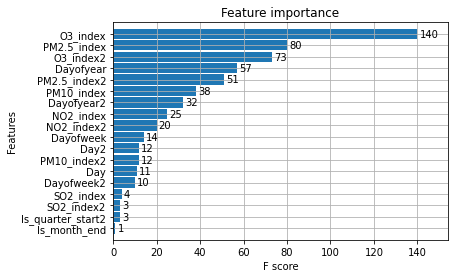

In [ ]:
_ = xgb.plot_importance(reg, height=0.9)

Визуализируем соответсвие предсказанных данных и исходного временного ряда

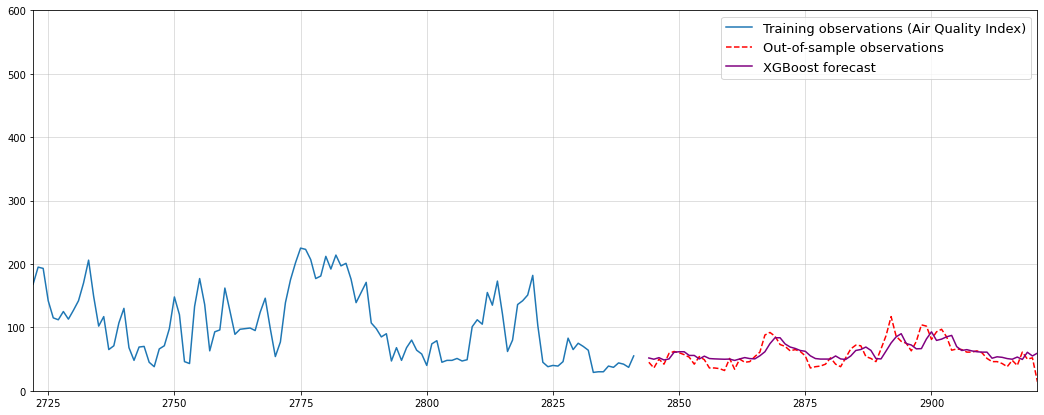

In [ ]:
prediction = reg.predict(x_test)
results = DataFrame(y_test)
results['Prediction'] = prediction

plt.figure(figsize=(18, 7))
plt.ylim([0, 600])
plt.grid(alpha=0.5)

plt.plot(y_train.iloc[-120:], label="Training observations (Air Quality Index)")
plt.plot(y_test['aqi'], color="red", label="Out-of-sample observations", ls="dashed")
plt.plot(results['Prediction'], color="purple", label="XGBoost forecast")

plt.legend(fontsize=13)
plt.margins(x=0)

Оценим ошибку (MAE)

In [ ]:
mean_absolute_error(y_test['aqi'], prediction)

9.861898471147587

Вследствие временного лага заложенного в обучаемых данных, и по графику видна задержка. Посчитаем ошибку сдвинув предказанное на этот лаг.

In [ ]:
shift_prediction = DataFrame(prediction)
shift_prediction = shift_prediction.shift(-2)

In [ ]:
shift_prediction.drop([76, 77], inplace=True)
y = y_test['aqi']
y = y.reset_index(drop=True)
y.drop([76, 77], inplace=True)
mean_absolute_error(y, shift_prediction)

7.563040582757247